# SegNet  
- Pytorch로 논문 구현  
- Data: CamVid (from Kaggle)
    - Train: 369개, Valid: 100개, Test: 232개
    
- accuracy를 측정할 metric으로는 mIoU를 사용  

# Packages and Modules

In [1]:
# packages and modules
import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from pytorchtools import EarlyStopping, Metrics, FocalLoss
from segnet_utils import load_image_with_resize

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [4]:
# 클래스 디렉토리 데이터 불러오기
data = pd.read_csv('./camvid/11_class_dict.csv', index_col=0)
data

,r,g,b
name,,,
Sky,128,128,128
Building,128,0,0
Pole,192,192,128
Road,128,64,128
Sidewalk,0,0,192
Tree,128,128,0
SignSymbol,192,128,128
Fence,64,64,128
Car,64,0,128


In [5]:
rgb_data = {name:list(data.loc[name, :]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

In [6]:
# cuda setting
device = torch.device('cuda')
print(device)

cuda


In [7]:
width = 224
height = 224
num_classes = len(data) # 12 classes (11 object classes and 1 background)

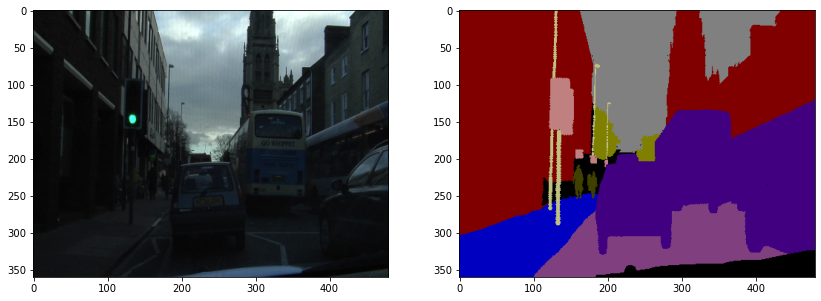

In [8]:
# show sample image
ex1 = Image.open('./camvid/train/train_images/0001TP_006690.png')
ex2 = Image.open('./camvid/train/train_labels/0001TP_006690_L.png')
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(ex1)
plt.subplot(122)
plt.imshow(ex2)
plt.show()

In [9]:
# load image data with resize
path = './camvid/'
train_image, train_label = load_image_with_resize(path, 
                                                  n_pixel_L=width, n_pixel_R=height, 
                                                  subset='train')
valid_image, valid_label = load_image_with_resize(path, 
                                                  n_pixel_L=width, n_pixel_R=height, 
                                                  subset='valid')

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [10]:
# image to 12 classes mask
def image2mask(labels):
    semantic_map = []
    for color in tqdm(list(rgb_data.values())):
        equality = np.equal(labels, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)

train_mask = image2mask(train_label)
valid_mask = image2mask(valid_label)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [11]:
# custom data set
class CamVidDataset(Dataset):
    def __init__(self, transforms_, subset='train'):
        self.transforms = transforms.Compose(transforms_)
        if subset=='train':
            self.images = train_image
            self.labels = train_mask
        elif subset=='valid':
            self.images = valid_image
            self.labels = valid_mask
        else:
            self.images = test_image
            self.labels = test_mask
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]
        return self.transforms(images), self.transforms(labels)

In [12]:
batch_size = 12

transforms_ = [
    transforms.ToTensor(),
]

train_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='train'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

valid_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='valid'),
    batch_size=len(valid_image),
    shuffle=True,
    drop_last=True
)

# Check data balancing

In [13]:
def get_class_total_num(class_name, data_label):
    class_count = 0
    for i in tqdm(range(len(data_label))):
        for j in range(data_label.shape[1]):
            for k in range(data_label.shape[2]):
                if (data_label[i][j,k,:] == rgb_data[class_name]).sum() == 3:
                    class_count += 1
    return class_count

In [14]:
# check counting of train data
Sky = get_class_total_num('Sky', train_label)
Building = get_class_total_num('Building', train_label)
Pole = get_class_total_num('Pole', train_label)
Road = get_class_total_num('Road', train_label)
Sidewalk = get_class_total_num('Sidewalk', train_label)
Tree = get_class_total_num('Tree', train_label)
SignSymbol = get_class_total_num('SignSymbol', train_label)
Fence = get_class_total_num('Fence', train_label)
Car = get_class_total_num('Car', train_label)
Pedestrian = get_class_total_num('Pedestrian', train_label)
Bicyclist = get_class_total_num('Bicyclist', train_label)
unlabelled = get_class_total_num('unlabelled', train_label)

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

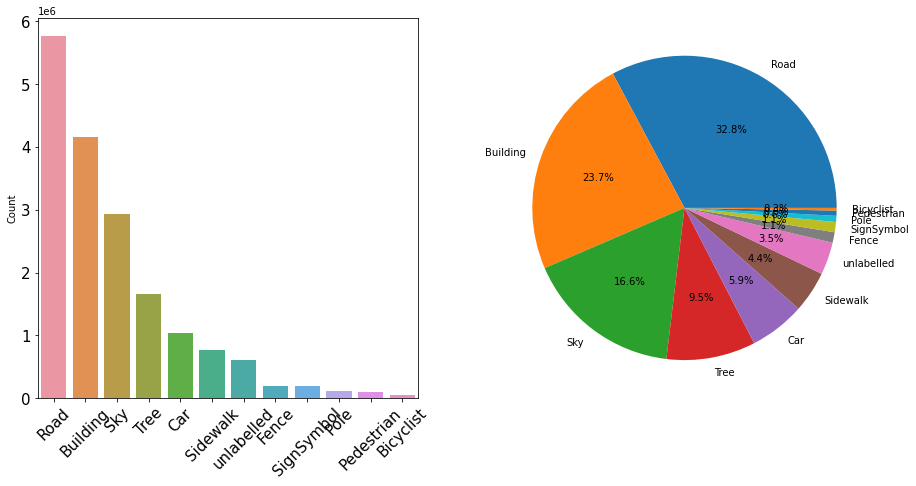

In [15]:
# create data frame
train_class_labels = list(rgb_data.keys())
train_class_count = [Sky, Building, Pole, Road, Sidewalk, Tree, SignSymbol, Fence, Car,
                     Pedestrian, Bicyclist, unlabelled]

train_class_df = pd.DataFrame(train_class_count, index=train_class_labels, columns=['Count'])
train_class_df = train_class_df.sort_values(by='Count', ascending=False)

# show plots
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.barplot(data=train_class_df, x=train_class_df.index, y='Count')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(122)
plt.pie(train_class_df['Count'], labels=train_class_df.index, autopct='%.1f%%')
plt.show()

In [16]:
# check counting of valid data
val_Sky = get_class_total_num('Sky', valid_label)
val_Building = get_class_total_num('Building', valid_label)
val_Pole = get_class_total_num('Pole', valid_label)
val_Road = get_class_total_num('Road', valid_label)
val_Sidewalk = get_class_total_num('Sidewalk', valid_label)
val_Tree = get_class_total_num('Tree', valid_label)
val_SignSymbol = get_class_total_num('SignSymbol', valid_label)
val_Fence = get_class_total_num('Fence', valid_label)
val_Car = get_class_total_num('Car', valid_label)
val_Pedestrian = get_class_total_num('Pedestrian', valid_label)
val_Bicyclist = get_class_total_num('Bicyclist', valid_label)
val_unlabelled = get_class_total_num('unlabelled', valid_label)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

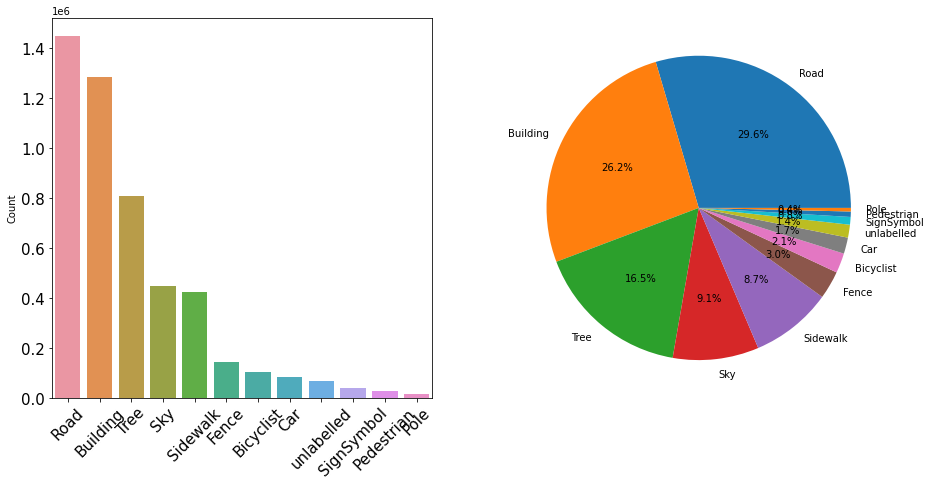

In [17]:
# create data frame
valid_class_labels = list(rgb_data.keys())
valid_class_count = [val_Sky, val_Building, val_Pole, val_Road, val_Sidewalk, val_Tree, val_SignSymbol, 
                     val_Fence, val_Car, val_Pedestrian, val_Bicyclist, val_unlabelled]

valid_class_df = pd.DataFrame(valid_class_count, index=valid_class_labels, columns=['Count'])
valid_class_df = valid_class_df.sort_values(by='Count', ascending=False)

# show plots
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.barplot(data=valid_class_df, x=valid_class_df.index, y='Count')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(122)
plt.pie(valid_class_df['Count'], labels=valid_class_df.index, autopct='%.1f%%')
plt.show()

## Build Model

In [18]:
# load pre-trained vgg16
vgg16 = models.vgg16(pretrained=True)

In [19]:
# define encoder block module using pre-trained vgg16
class EncoderBlock(nn.Module):
    def __init__(self, index):
        super(EncoderBlock, self).__init__()
        # build encoder network (Conv + BN + ReLU)
        self.block = nn.Sequential(
            vgg16.features[index],
            nn.BatchNorm2d(vgg16.features[index].out_channels),
            nn.ReLU(inplace=True),
        )
        self._initialize_weights_()                    
        
    # he normal initialization
    def _initialize_weights_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        return self.block(x)

In [20]:
# define encoder block module
class DecoderBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DecoderBlock, self).__init__()
        # build decoder network (Conv + BN + ReLU)
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
        )
        self._initialize_weights_()
        
    # he normal initialization
    def _initialize_weights_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        return self.block(x)

In [21]:
class SegNet(nn.Module):
    def __init__(self, num_filters=64, in_dim=3, out_dim=num_classes):
        super(SegNet, self).__init__()
        # define convolution layer indices of vgg16 
        self.vgg_conv_index = [0,2,5,7,10,12,14,17,19,21,24,26,28]
        
        ### stage 1, 2 has 2 of Conv layer + Batch Norm layer + ReLU activation layer
        ### stage 3, 4, 5 has 3 of Conv layer + Batch Norm layer + ReLU activation layer
        
        ######################### ENCODER #########################
        # define max pooling layer
        self.MaxPooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # first encoding
        self.encoder1 = EncoderBlock(self.vgg_conv_index[0])
        self.encoder2 = EncoderBlock(self.vgg_conv_index[1])
        # second encoding
        self.encoder3 = EncoderBlock(self.vgg_conv_index[2])
        self.encoder4 = EncoderBlock(self.vgg_conv_index[3])
        # third encoding
        self.encoder5 = EncoderBlock(self.vgg_conv_index[4])
        self.encoder6 = EncoderBlock(self.vgg_conv_index[5])
        self.encoder7 = EncoderBlock(self.vgg_conv_index[6])
        # fourth encoding
        self.encoder8 = EncoderBlock(self.vgg_conv_index[7])
        self.encoder9 = EncoderBlock(self.vgg_conv_index[8])
        self.encoder10 = EncoderBlock(self.vgg_conv_index[9])
        # fifth encoding
        self.encoder11 = EncoderBlock(self.vgg_conv_index[10])
        self.encoder12 = EncoderBlock(self.vgg_conv_index[11])
        self.encoder13 = EncoderBlock(self.vgg_conv_index[12])
        
        ###########################################################
        ######################## SYMMETRIC ########################
        ###########################################################
        
        ######################### DECODER #########################
        # define max-pooling indices layer
        self.MaxUnPooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # first decoding
        self.decoder1 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder2 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder3 = DecoderBlock(num_filters*8, num_filters*8)
        # second decoding
        self.decoder4 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder5 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder6 = DecoderBlock(num_filters*8, num_filters*4)
        # third decoding
        self.decoder7 = DecoderBlock(num_filters*4, num_filters*4)
        self.decoder8 = DecoderBlock(num_filters*4, num_filters*4)
        self.decoder9 = DecoderBlock(num_filters*4, num_filters*2)
        # fourth decoding
        self.decoder10 = DecoderBlock(num_filters*2, num_filters*2)
        self.decoder11 = DecoderBlock(num_filters*2, num_filters)
        # fifth decoding
        self.decoder12 = DecoderBlock(num_filters, num_filters)
        self.decoder13 = DecoderBlock(num_filters, out_dim)
        # softmax classifier
        self.classifier = nn.Softmax()
        
    def forward(self, x):
        ######################### ENCODING #########################
        # stage 1
        size1 = x.size()
        x = self.encoder1(x)
        x = self.encoder2(x)
        x, idx1 = self.MaxPooling(x)
        # stage 2
        size2 = x.size()
        x = self.encoder3(x)
        x = self.encoder4(x)
        x, idx2 = self.MaxPooling(x)
        # stage 3
        size3 = x.size()
        x = self.encoder5(x)
        x = self.encoder6(x)
        x = self.encoder7(x)
        x, idx3 = self.MaxPooling(x)
        # stage 4
        size4 = x.size()
        x = self.encoder8(x)
        x = self.encoder9(x)
        x = self.encoder10(x)
        x, idx4 = self.MaxPooling(x)
        # stage 5
        size5 = x.size()
        x = self.encoder11(x)
        x = self.encoder12(x)
        x = self.encoder13(x)
        x, idx5 = self.MaxPooling(x)
        
        ######################### DECODING #########################
        # stage 5
        x = self.MaxUnPooling(x, idx5, output_size=size5)
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        # stage 4
        x = self.MaxUnPooling(x, idx4, output_size=size4)
        x = self.decoder4(x)
        x = self.decoder5(x)
        x = self.decoder6(x)
        # stage 3
        x = self.MaxUnPooling(x, idx3, output_size=size3)
        x = self.decoder7(x)
        x = self.decoder8(x)
        x = self.decoder9(x)
        # stage 2
        x = self.MaxUnPooling(x, idx2, output_size=size2)
        x = self.decoder10(x)
        x = self.decoder11(x)
        # stage 1
        x = self.MaxUnPooling(x, idx1, output_size=size1)
        x = self.decoder12(x)
        out = self.decoder13(x)
        # apply softmax activation function
        softmax_output = self.classifier(out)
        
        return out, softmax_output

In [22]:
model = SegNet().to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
      EncoderBlock-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
      EncoderBlock-8         [-1, 64, 224, 224]               0
         MaxPool2d-9  [[-1, 64, 112, 112], [-1, 64, 112, 112]]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
      BatchNorm2d-11        [-1, 128, 112, 112]             256
             ReLU-12        [-1, 128, 112, 112]               0
     EncoderBlock-13        [-1, 128, 112, 112]               0
           Conv2d-14    

# Set Loss function, Optimizer, learning rate scheduler and early stopping  
- loss : focal loss for semantic segmentation  
$$CE\left(p_t\right)=-\log\left(p_t\right)$$  
$$FL\left(p_t\right)=\alpha_t\left(1-p_t\right)^{\gamma}\times CE\left(p_t\right)$$  
$$\Rightarrow -\alpha\left(1-p_t\right)^{\gamma}\log\left(p_t\right)$$

In [23]:
# set learning rate scheduler to reduce loss
lr = 1e-3
loss_func = FocalLoss(alpha=0.9, gamma=2., reduction='mean') #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1, verbose=True)
early_stopping = EarlyStopping(patience=20, verbose=True, path='./model/checkpoint.pt')
metric = Metrics(n_classes=num_classes, dim=1)

# Train Model

In [24]:
# define model training function
def train(model, 
          train_data, 
          validation_data,epochs,
          learning_rate_scheduler=False,
          early_stop=False):
    
    loss_list, val_loss_list = [], []
    miou_list, val_miou_list = [], []
    # train the model
    model.train()
    starting = time.time()
    for epoch in tqdm(range(epochs)):
        init_time = time.time()
        for train_images, train_labels in train_data:
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)
            
            optimizer.zero_grad()
            
            output_images, _  = model(train_images)
            loss = loss_func(output_images, train_labels)
            train_miou = metric.get_miou(output_images, train_labels)
            
            loss.backward()
            optimizer.step()
        end_time = time.time()
        loss_list.append(loss.item())
        miou_list.append(train_miou.item())
        
        print(f'\n[Epoch {epoch+1}/{epochs}]'
              f'  [Loss: {loss.item():.3f}]'
              f'  [mIoU: {train_miou.item():.3f}]'
              f'  [time: {end_time-init_time:.3f}s]')
        # validate the model
        with torch.no_grad():
            for val_images, val_labels in validation_data:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs, _ = model(val_images)
                val_loss = loss_func(val_outputs, val_labels)
                val_miou = metric.get_miou(val_outputs, val_labels)
                
                if learning_rate_scheduler:
                    lr_scheduler.step(val_loss)
                
            val_loss_list.append(val_loss.item())
            val_miou_list.append(val_miou.item())
            
            print(f'[validation loss: {val_loss.item():.3f}]'
                  f'   [validation mIoU: {val_miou.item():.3f}]')
            
        # set early stopping
        if early_stop:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print('\n##########################\n'
                      '##### Early Stopping #####\n'
                      '##########################')
                break
            
    ending = time.time()
    print(f'\nTotal time for training is {ending-starting:.3f}s')
    return model, loss_list, val_loss_list, miou_list, val_miou_list

In [25]:
# model training
EPOCH = 100

model, train_loss, valid_loss, train_miou, valid_miou = train(
    model,
    train_loader,
    validation_data=valid_loader,
    epochs=EPOCH,
    learning_rate_scheduler=True,
    early_stop=True
)

  0%|          | 0/100 [00:00<?, ?it/s]


[Epoch 1/100]  [Loss: 0.285]  [mIoU: 0.157]  [time: 4.554s]
[validation loss: 0.327]   [validation mIoU: 0.151]
Validation loss decreased (inf --> 0.327).  Saving model ...

[Epoch 2/100]  [Loss: 0.229]  [mIoU: 0.195]  [time: 4.148s]
[validation loss: 0.238]   [validation mIoU: 0.210]
Validation loss decreased (0.327 --> 0.238).  Saving model ...

[Epoch 3/100]  [Loss: 0.160]  [mIoU: 0.282]  [time: 4.153s]
[validation loss: 0.187]   [validation mIoU: 0.277]
Validation loss decreased (0.238 --> 0.187).  Saving model ...

[Epoch 4/100]  [Loss: 0.150]  [mIoU: 0.303]  [time: 4.110s]
[validation loss: 0.157]   [validation mIoU: 0.298]
Validation loss decreased (0.187 --> 0.157).  Saving model ...

[Epoch 5/100]  [Loss: 0.131]  [mIoU: 0.300]  [time: 4.106s]
[validation loss: 0.139]   [validation mIoU: 0.309]
Validation loss decreased (0.157 --> 0.139).  Saving model ...

[Epoch 6/100]  [Loss: 0.119]  [mIoU: 0.301]  [time: 4.215s]
[validation loss: 0.109]   [validation mIoU: 0.343]
Validatio


[Epoch 51/100]  [Loss: 0.007]  [mIoU: 0.555]  [time: 3.991s]
[validation loss: 0.037]   [validation mIoU: 0.425]
EarlyStopping counter: 1 out of 20

[Epoch 52/100]  [Loss: 0.007]  [mIoU: 0.598]  [time: 4.066s]
[validation loss: 0.035]   [validation mIoU: 0.429]
Validation loss decreased (0.035 --> 0.035).  Saving model ...

[Epoch 53/100]  [Loss: 0.005]  [mIoU: 0.627]  [time: 4.001s]
[validation loss: 0.036]   [validation mIoU: 0.423]
EarlyStopping counter: 1 out of 20

[Epoch 54/100]  [Loss: 0.004]  [mIoU: 0.625]  [time: 4.088s]
[validation loss: 0.035]   [validation mIoU: 0.429]
EarlyStopping counter: 2 out of 20

[Epoch 55/100]  [Loss: 0.005]  [mIoU: 0.574]  [time: 3.994s]
[validation loss: 0.034]   [validation mIoU: 0.431]
Validation loss decreased (0.035 --> 0.034).  Saving model ...

[Epoch 56/100]  [Loss: 0.003]  [mIoU: 0.673]  [time: 4.005s]
[validation loss: 0.035]   [validation mIoU: 0.426]
EarlyStopping counter: 1 out of 20

[Epoch 57/100]  [Loss: 0.003]  [mIoU: 0.639]  [ti

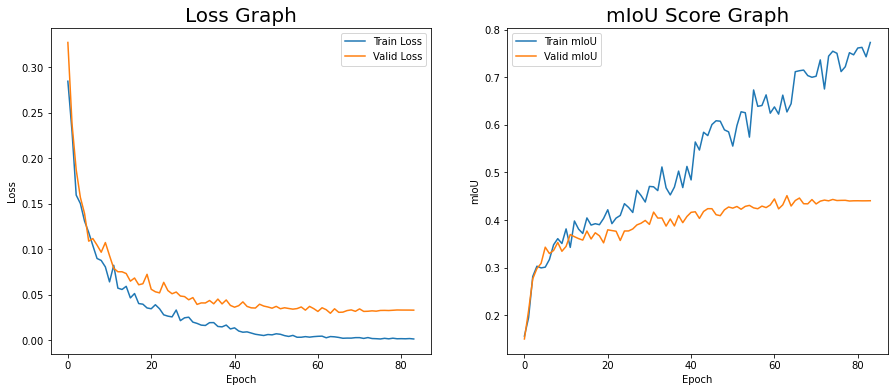

In [26]:
# check losses and miou scores graph
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_title('Loss Graph', fontsize=20)
ax[0].plot(np.arange(len(train_loss)), train_loss, label='Train Loss')
ax[0].plot(np.arange(len(valid_loss)), valid_loss, label='Valid Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[1].set_title('mIoU Score Graph', fontsize=20)
ax[1].plot(np.arange(len(train_miou)), train_miou, label='Train mIoU')
ax[1].plot(np.arange(len(valid_miou)), valid_miou, label='Valid mIoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('mIoU')
ax[1].legend(loc='best')
fig.show()

# Test

In [27]:
# load saved model
model = SegNet().to(device)
model.load_state_dict(torch.load('./model/checkpoint.pt'))

<All keys matched successfully>

In [28]:
# load test data
test_image, test_label = load_image_with_resize(path, 
                                                n_pixel_L=width, n_pixel_R=height,
                                                subset='test')
test_mask = image2mask(test_label)

test_loader = DataLoader(
    CamVidDataset(transforms_, subset='test'),
    batch_size=len(test_image),
    drop_last=True,
    shuffle=False
)

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [29]:
# test
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        # predict
        test_outputs, _ = model(test_images)
        loss = loss_func(test_outputs, test_labels)
        test_miou = metric.get_miou(test_outputs, test_labels)
        print(f'Test Loss: {loss.item():.3f},'
              f'  Test mIoU: {test_miou:.3f}')

Test Loss: 0.066,  Test mIoU: 0.354


In [ ]:
# The outputs of test has a value between 0 and 1 
# so, we need to change one hot vector to each vector of outputs
"""
def pred2one_hot(outputs):
    outputs = outputs.detach().cpu().numpy()
    for i in tqdm(range(len(outputs))):
        for j in range(outputs.shape[2]):
            for k in range(outputs.shape[3]):
                outputs[i][:,j,k] = np.where(outputs[i][:,j,k]<outputs[i][:,j,k].max(), 0, 1)
    return outputs
"""

In [30]:
# 12 classes channels to 3 RGB channels
def map_class_to_rgb(p):
    return rgb_array[p[0]]

def mask2rgb(images):
    rgb_img_list = []
    for img in tqdm(images):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        img = np.argmax(img, axis=-1)
        rgb_img = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(img, -1))
        rgb_img_list.append(rgb_img)
    return np.array(rgb_img_list)

test_result = mask2rgb(test_outputs)

  0%|          | 0/233 [00:00<?, ?it/s]

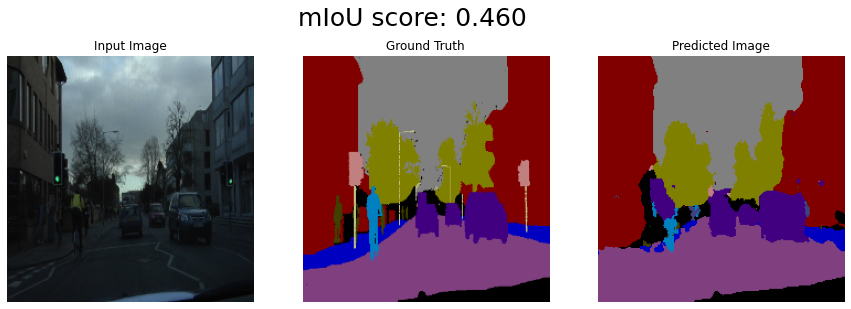

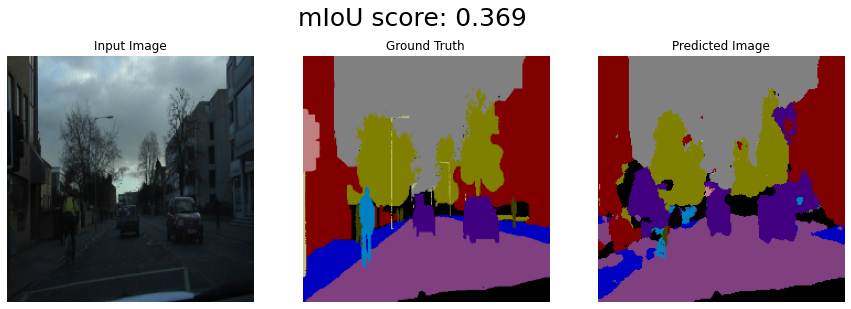

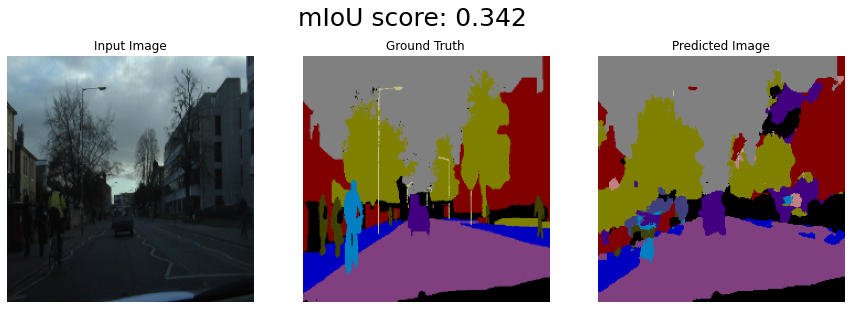

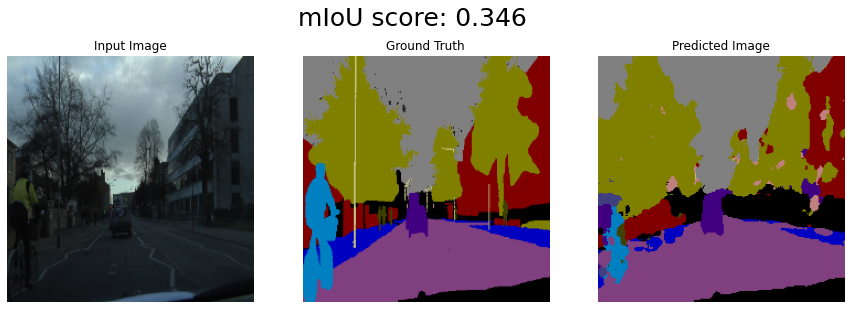

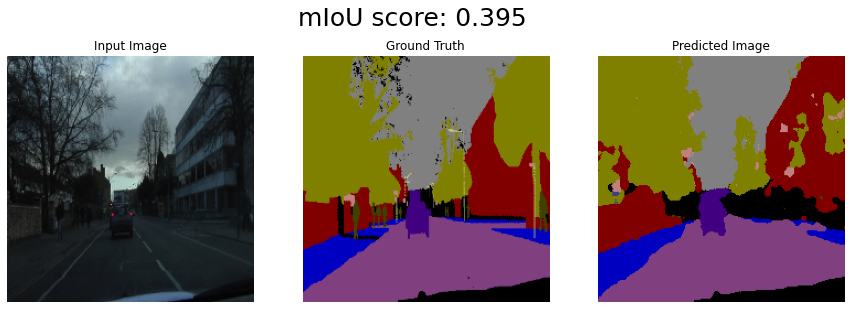

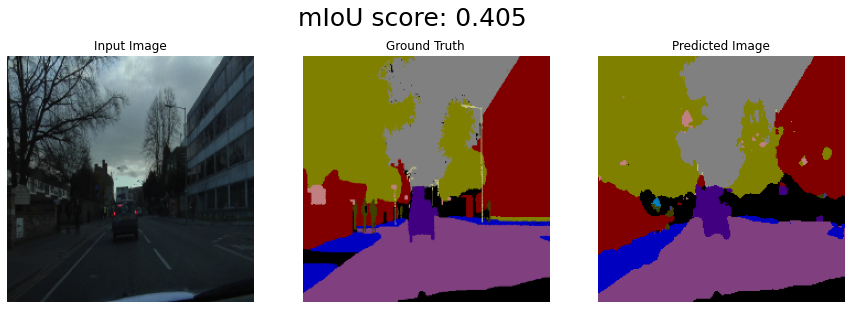

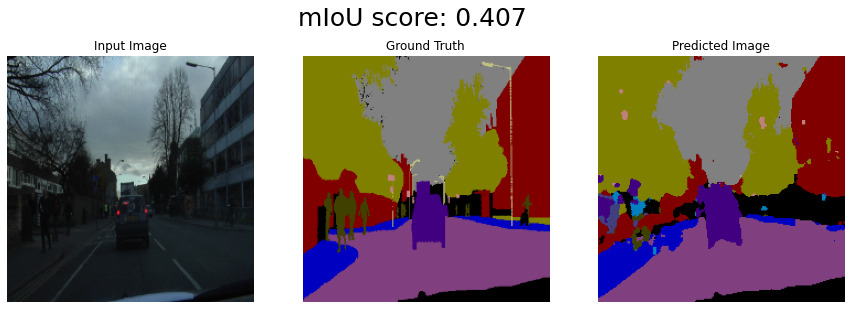

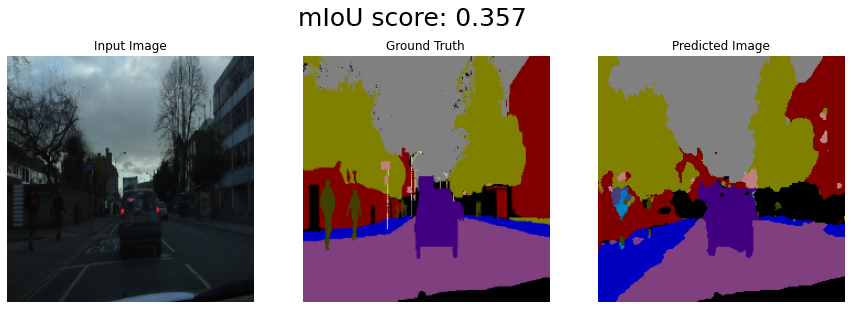

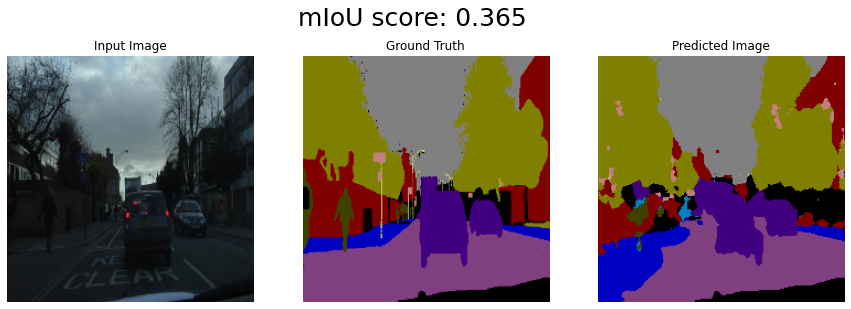

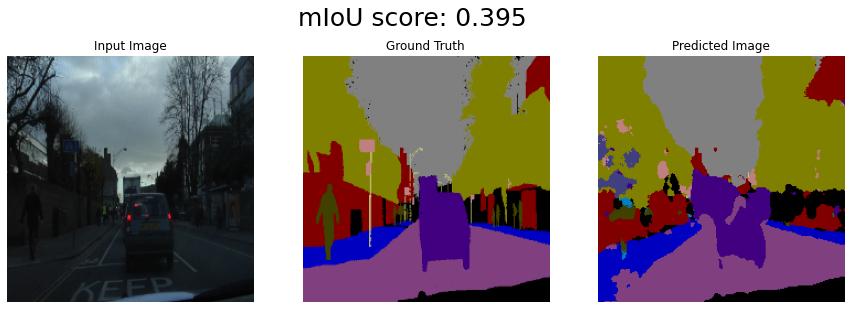

In [32]:
# show test outputs with miou score
test_metric = Metrics(n_classes=num_classes, dim=0)

def show_result(image, label, mask, model_pred, rgb_pred, ncols):
    for i in range(ncols):
        # get miou score
        miou = test_metric.get_miou(mask[i], model_pred[i])
        # plot images
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        fig.suptitle(f'mIoU score: {miou:.3f}', fontsize=25)
        ax[0].imshow(image[i])
        ax[0].axis('off')
        ax[0].set_title('Input Image')
        ax[1].imshow(label[i])
        ax[1].axis('off')
        ax[1].set_title(f'Ground Truth')
        ax[2].imshow(rgb_pred[i])
        ax[2].axis('off')
        ax[2].set_title(f'Predicted Image')
        fig.show()
        
show_result(test_image, test_label, test_labels, test_outputs, test_result, 10)